# Comparaison entre les 2 signaux sur une même fenêtre d'observation

## Importation des librairies nécéssaires

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from statsmodels.tsa.seasonal import STL
import statsmodels.api as sm
from datetime import datetime
from scipy import signal

# Preparation des données

## Importation

In [6]:
data_real = pd.read_csv('./data1.csv', sep=";")
data_real_2 = pd.read_csv('./data2.csv', sep=";")

## Affichage

In [8]:
#  Série 1
data = data_real.iloc[:, [0, 1, 6]].to_numpy()
time_serie = pd.Series(data[:, 2], dtype='float64')
time_serie = time_serie.dropna()

#  Série 2
data2 = data_real_2.iloc[:, [0, 1, 6]].to_numpy()
time_serie2 = pd.Series(data2[:, 2], dtype='float64')
time_serie2 = time_serie2.dropna()

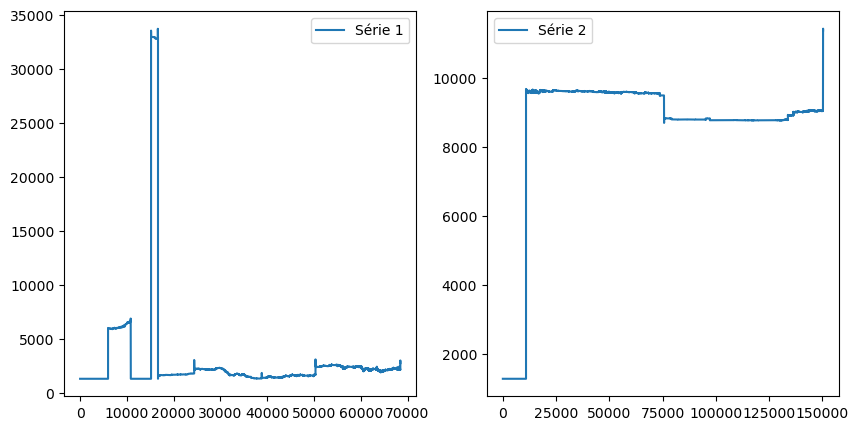

In [9]:
# Affichage des séries
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(time_serie, label='Série 1')
ax[0].legend()
ax[1].plot(time_serie2, label='Série 2')
ax[1].legend()
plt.show()

# Nettoyage des données

Dans le deuxieme signal, on a avait pu observer que certaines données étaient dupliquées. On va donc commencer par les supprimer afin de n'avoir qu'une observation par date

In [12]:
# Suppression données dupliquées série 2
df_crop = pd.DataFrame(data2)
df_crop = df_crop.drop_duplicates(subset=1, keep='first')

On ne sélectionne que les données que l'on va utiliser pour la suite de l'analyse. Cela correespond aux données prises entre 2021.08.05 16:20  et 2021.08.31 23:55.

Dates des relevés de la série 1 :  2021.08.05 16:20  -  2021.08.31 23:55
Nombre de données séries 1 :  7580
Dates des relevés de la série 2 :  2021.08.05 16:20  -  2021.08.31 23:55
Nombre de données séries 2 :  7580


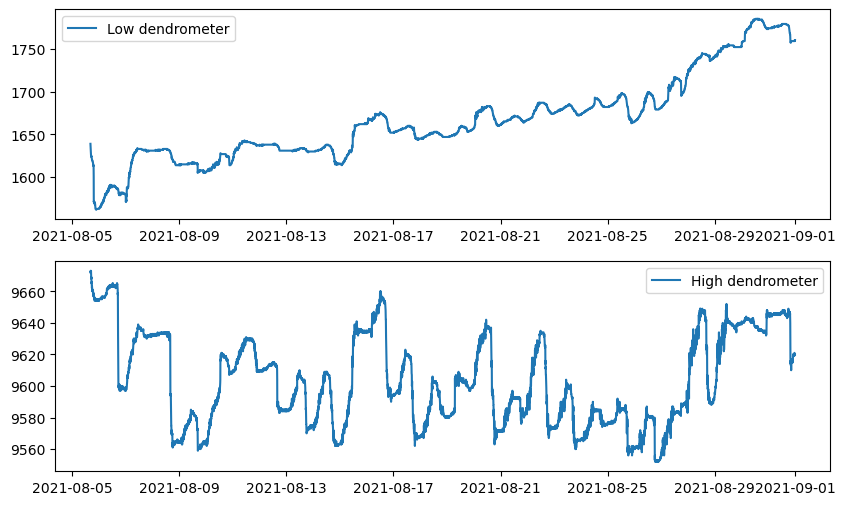

In [14]:
# Fenêtre d'observation série 1
data_crop = data[16656:24236,:] 
time_serie_crop = pd.Series(data_crop[:,2], dtype='float64')

# Fenêtre d'observation série 2
data_crop2 = df_crop.iloc[10884:18464, :].to_numpy()
time_serie_crop2 = pd.Series(data_crop2[:,2], dtype='float64')

# Création de l'axe des abscisses (dates)
data_time = data_crop[:, 1] 
datetime_data = [datetime.strptime(d, "%Y.%m.%d %H:%M") for d in data_time]

# Vérification des fenêtres d'observations
print("Dates des relevés de la série 1 : ", data_crop[0,1], " - ", data_crop[-1,1])
print("Nombre de données séries 1 : ", len(data_crop[:,1]))
print("Dates des relevés de la série 2 : ", data_crop2[0,1], " - ", data_crop2[-1,1])
print("Nombre de données séries 2 : ", len(data_crop2[:,1]))

# Affichage des séries
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
ax[0].plot(datetime_data,time_serie_crop, label='Low dendrometer')
ax[0].legend()
ax[1].plot(datetime_data,time_serie_crop2, label='High dendrometer')
ax[1].legend()
plt.show()

On a bien la même fenêtre d'étude pour les 2 signaux et le même nombre d'observations.

On vérifie maintenant que l'on a la même fréquence d'observation, c'est à dire des mesures prises toutes les 5 minutes

In [16]:
# Pas de temps de la série 1
data_time = data_real.iloc[16656:24236, 1].to_numpy()
datetime_data = [datetime.strptime(d, "%Y.%m.%d %H:%M") for d in data_time]
differences_minutes = [
    (datetime_data[i] - datetime_data[i-1]).total_seconds() / 60
    for i in range(1, len(datetime_data))
]

print("Difference between two measurements for the first time serie : ")
print(np.unique(differences_minutes))

# Pas de temps de la série 2
data_time2 = df_crop.iloc[10884:18464, 1].to_numpy()
datetime_data2 = [datetime.strptime(d, "%Y.%m.%d %H:%M") for d in data_time2]
differences_minutes2 = [
    (datetime_data2[i] - datetime_data2[i-1]).total_seconds() / 60
    for i in range(1, len(datetime_data2))
]

print("Difference between two measurements for the second time serie :")
print(np.unique(differences_minutes2))


Difference between two measurements for the first time serie : 
[5.]
Difference between two measurements for the second time serie :
[5.]


# Autocorrélation des signaux

Dans un premier temps on va regarder l'autocorrélation des signaux avec eux mêmes.

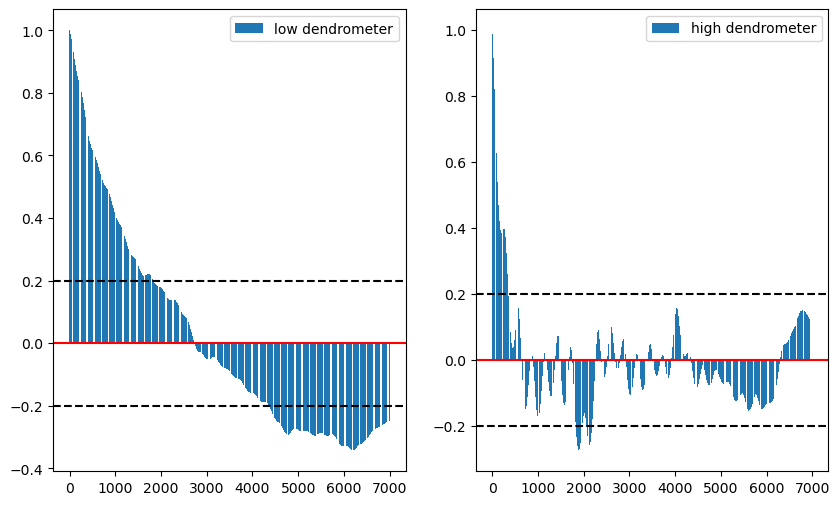

In [18]:
max_lag = 7000
acf_values_1 = sm.tsa.acf(time_serie_crop, nlags = max_lag)
acf_values_2 = sm.tsa.acf(time_serie_crop2, nlags = max_lag)

# Affichage de l'autocorrélation
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].bar(range(max_lag + 1), acf_values_1, label='low dendrometer')
ax[0].axhline(y=0.2, color='black', linestyle='--')
ax[0].axhline(y=0, color='red')
ax[0].axhline(y=-0.2, color='black', linestyle='--')
ax[0].legend()
ax[1].bar(range(max_lag + 1), acf_values_2, label='high dendrometer')
ax[1].axhline(y=0.2, color='black', linestyle='--')
ax[1].axhline(y=0, color='red')
ax[1].axhline(y=-0.2, color='black', linestyle='--')
ax[1].legend()
plt.show()

**Observation**

On remarque que pour le premier signal on a un ACF assez mauvaise. Cela peut s'expliquer car le premier signal est plus bruité que le 2e. Nous le verrons de manière plus évidente dans la suite.
Pour le deuxième signal, on peut observer que seuls 2 pics sont supérieurs à 0.2 en valeur absolue. 

On peut observer deux comportements distincts en ce qui concerne l'ACF. Le premier présente une décroissance soulignant l'importance de la tendance dans le signal, tandis que le second met davantage en évidence la saisonnalité avec l'oscillation entre des valeurs positives et négatives. Toutefois, ces oscillations se situent pour la plupart à l'intérieur des limites de signification, ce qui suggère que le signal est presque stationnaire. Cela peut expliquer pourquoi la saisonnalité est si difficile à extraire.


## Transformée de Fourier

Dans un premier temps, on a applique une transformée de Fourier sur nos signaux pour voir si l'on peut, à l'aide de cette méthode, isoler une composante cyclique. 


Dans le graphe, on prend la première moitié des fréquences et des amplitudes, car la seconde moitié (au-delà de la fréquence de Nyquist) est symétrique et n'apporte pas d'information nouvelle pour un signal réel.

In [22]:
# Fonction qui permet de passer l'axe des abscisses en jours
def freq_to_day (freq) :
    return (1/freq)/(60*24*24)

Période ayant la plus grande amplitude signal 1 : 2.2689176245210727 j
Période ayant la plus grande amplitude signal 2 : 21.93287037037037 j


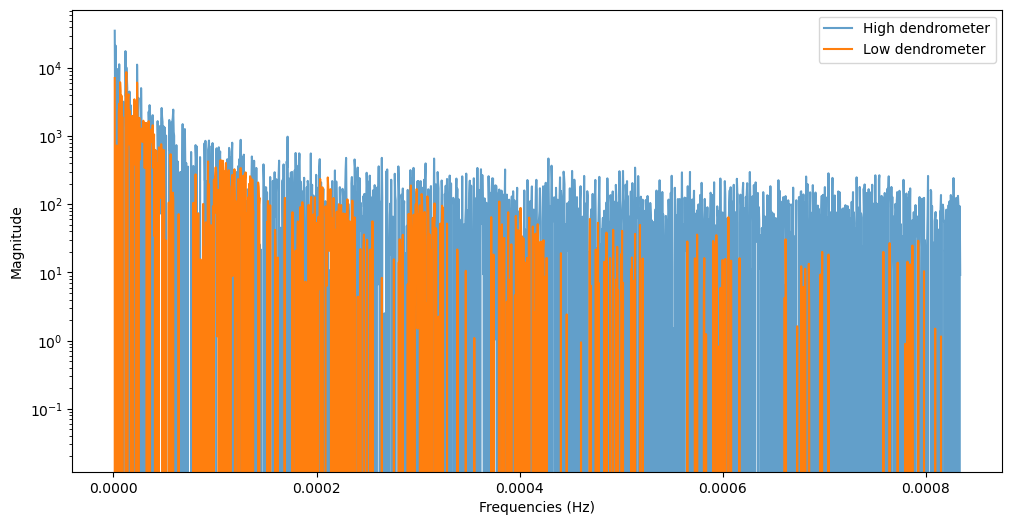

In [23]:
amplitudes1 = np.real(np.fft.rfft(time_serie_crop))[3:] # Les 2 premières sont bizarres
frequencies1 = np.fft.rfftfreq(len(time_serie_crop),5*60)[3:] # 900 = 5*60 : un point tout les 5 min

amplitudes2 = np.real(np.fft.rfft(time_serie_crop2))[3:] # Les 2 premières sont bizarres
frequencies2 = np.fft.rfftfreq(len(time_serie_crop2),5*60)[3:] # 900 = 5*60 : un point tout les 5 min

plt.figure(figsize=(12, 6))
plt.semilogy(frequencies2[:len(frequencies2)//2], amplitudes2[:len(amplitudes2)//2], label='High dendrometer', alpha=0.7)
plt.semilogy(frequencies1[:len(frequencies1)//2], amplitudes1[:len(amplitudes1)//2], label='Low dendrometer')
# Affichage du spectre avec les amplitudes moyennes par bloc
plt.legend()
plt.xlabel('Frequencies (Hz)')
plt.ylabel('Magnitude')
print("Période ayant la plus grande amplitude signal 1 :", freq_to_day(frequencies1[np.argmax(amplitudes1)]),"j" )
print("Période ayant la plus grande amplitude signal 2 :", freq_to_day(frequencies2[np.argmax(amplitudes2)]),"j" )

**Observations**

On remarque que la transformée de Fourier sur le 1e signal (orange) fait apparaître des harmoniques alors que le second non. On peut en conclure que le second signal est très bruité et donc on arrive moins à détecter ces composantes. 

Lorsque l'on regarde quelles sont les fréquences correspondantes aux plus grandes amplitudes, le 1er signal détecte une composante de 2 jours environ ce qui est très proche de celle que l'on cherche correspondante à 1 jour.

### Detection harmoniques par peaks

On va essayer 2 méthodes afin d'isoler ces harmoniques que l'on peut voir apparaître. La première est la méthode "peaks" qui sur un chunk de taille 50 prend la fréquences correspondant à la plus grande amplitude.

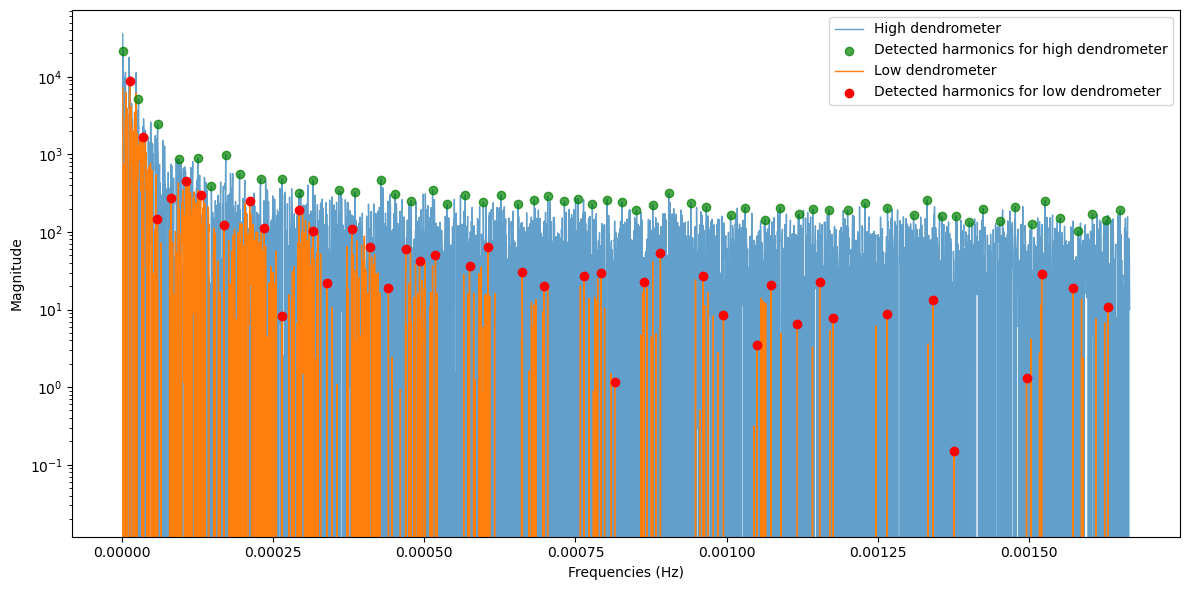

----- Harmoniques ordre 1 -----
Harmoniques détectées signal 1:
Fréquence : 0.000013 Hz, Fréquence : 2.268918 jours, Amplitude : 8768.55
Harmoniques détectées signal 2:
Fréquence : 0.000002 Hz, Fréquence : 13.159722 jours, Amplitude : 21500.12
----- Harmoniques ordre 2 -----
Harmoniques détectées signal 1:
Fréquence : 0.000035 Hz, Fréquence : 0.832894 jours, Amplitude : 1672.59
Harmoniques détectées signal 2:
Fréquence : 0.000027 Hz, Fréquence : 1.061268 jours, Amplitude : 5106.66


In [26]:
from scipy.signal import find_peaks

# Détection des pics
peaks1, properties1 = find_peaks(amplitudes1, prominence=1, distance=50)
peaks2, properties2 = find_peaks(amplitudes2, prominence=1, distance=50)

# Extraction des harmoniques
harmonic_frequencies1 = frequencies1[peaks1]
harmonic_amplitudes1 = amplitudes1[peaks1]
harmonic_frequencies2 = frequencies2[peaks2]
harmonic_amplitudes2 = amplitudes2[peaks2]

# Tracé du spectre et des harmoniques
plt.figure(figsize=(12, 6))
plt.plot(frequencies2, amplitudes2, label='High dendrometer', linewidth=1,alpha=0.7)
plt.scatter(harmonic_frequencies2, harmonic_amplitudes2, color='green', alpha=0.7,label='Detected harmonics for high dendrometer', zorder=5)
plt.plot(frequencies1, amplitudes1, label='Low dendrometer', linewidth=1)
plt.scatter(harmonic_frequencies1, harmonic_amplitudes1, color='red', label='Detected harmonics for low dendrometer', zorder=5)
plt.xlabel('Frequencies (Hz)')
plt.ylabel('Magnitude')
plt.xscale('linear')
plt.yscale('log')  # Échelle logarithmique pour clarifier les pics
plt.legend()
plt.tight_layout()
plt.show()

print("----- Harmoniques ordre 1 -----")
print("Harmoniques détectées signal 1:")
print(f"Fréquence : {harmonic_frequencies1[0]:.6f} Hz, Fréquence : {freq_to_day(harmonic_frequencies1[0]):.6f} jours, Amplitude : {harmonic_amplitudes1[0]:.2f}")
print("Harmoniques détectées signal 2:")
print(f"Fréquence : {harmonic_frequencies2[0]:.6f} Hz, Fréquence : {freq_to_day(harmonic_frequencies2[0]):.6f} jours, Amplitude : {harmonic_amplitudes2[0]:.2f}")

print("----- Harmoniques ordre 2 -----")
print("Harmoniques détectées signal 1:")
print(f"Fréquence : {harmonic_frequencies1[1]:.6f} Hz, Fréquence : {freq_to_day(harmonic_frequencies1[1]):.6f} jours, Amplitude : {harmonic_amplitudes1[1]:.2f}")
print("Harmoniques détectées signal 2:")
print(f"Fréquence : {harmonic_frequencies2[1]:.6f} Hz, Fréquence : {freq_to_day(harmonic_frequencies2[1]):.6f} jours, Amplitude : {harmonic_amplitudes2[1]:.2f}")


**Observation**

Au vu de la méthode, cela parait évident que l'on détecte les mêmes composantes cycliques que précédemment pour l'harmonique d'ordre 1. Cela s'explique car nos signaux sont bruités et on arrive donc pas parfaitement à détecter la bonne composante.

Cependant on peut remarquer que pour l'harmonique d'ordre 2, on arrive à détecter (à peu près) la composante du cycle diurne avec une distance de 50 points.

### Detection harmoniques par moyenne par chunk

Dans cette méthode nous nous interessons non plus à la plus grande valeur sur une taille de chunk donnée mais à la moyenne des amplitudes (et donc des fréquences).

Pour cela on va comparer nos résultats avec 2 tailles de chunk différentes.

In [29]:
def average_by_chunk(frequencies, amplitudes, chunk_size=50):
    # Calcul du nombre de blocs
    num_chunks = len(frequencies) // chunk_size
    avg_frequencies = []
    avg_amplitudes = []
    
    # Diviser en blocs et calculer la moyenne
    for i in range(num_chunks):
        start_idx = i * chunk_size
        end_idx = start_idx + chunk_size
        
        # Sélectionner les indices du bloc
        chunk_frequencies = frequencies[start_idx:end_idx]
        chunk_amplitudes = amplitudes[start_idx:end_idx]
        
        # Calculer la fréquence moyenne (c'est la fréquence du centre du bloc)
        avg_frequency = np.mean(chunk_frequencies)
        
        # Calculer l'amplitude moyenne du bloc
        avg_amplitude = np.mean(chunk_amplitudes)
        
        avg_frequencies.append(avg_frequency)
        avg_amplitudes.append(avg_amplitude)
    
    return np.array(avg_frequencies), np.array(avg_amplitudes)


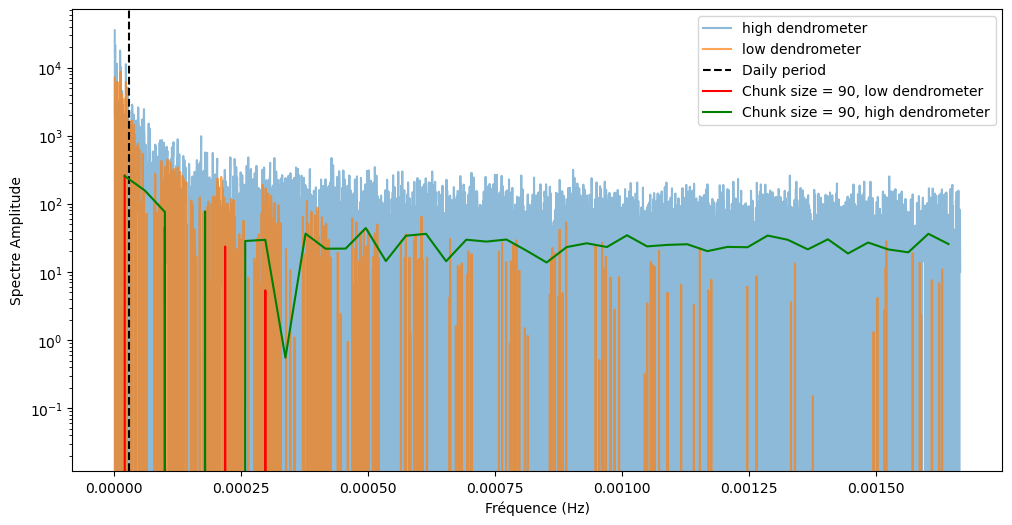

Harmoniques détectées signal 1:
Fréquence : 0.000021 Hz, Fréquence : 1.385234 jours, Amplitude : 261.63
Harmoniques détectées signal 2:
Fréquence : 0.000021 Hz, Fréquence : 1.385234 jours, Amplitude : 256.58


In [30]:
chunk_size = 90
frequencies1_avg_90, amplitudes1_avg_90 = average_by_chunk(frequencies1, amplitudes1, chunk_size)
frequencies2_avg_90, amplitudes2_avg_90 = average_by_chunk(frequencies2, amplitudes2, chunk_size)

plt.figure(figsize=(12, 6))
plt.semilogy(frequencies2, amplitudes2, label='high dendrometer', alpha=0.5)
plt.semilogy(frequencies1, amplitudes1, label='low dendrometer', alpha=0.7)
plt.axvline(x=1/(60*24*24), color='black', linestyle='--',label='Daily period')
plt.semilogy(frequencies1_avg_90, amplitudes1_avg_90,  label='Chunk size = 90, low dendrometer', color='red')
plt.semilogy(frequencies2_avg_90, amplitudes2_avg_90,  label='Chunk size = 90, high dendrometer', color='green')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Spectre Amplitude')
plt.legend()
plt.show()

print("Harmoniques détectées signal 1:")
print(f"Fréquence : {frequencies1_avg_90[0]:.6f} Hz, Fréquence : {freq_to_day(frequencies1_avg_90[0]):.6f} jours, Amplitude : {amplitudes1_avg_90[0]:.2f}")
print("Harmoniques détectées signal 2:")
print(f"Fréquence : {frequencies2_avg_90[0]:.6f} Hz, Fréquence : {freq_to_day(frequencies2_avg_90[0]):.6f} jours, Amplitude : {amplitudes2_avg_90[0]:.2f}")


**Observations**

On observe que pour une taulle de chunk de 90, la moyenne pour les 2 signaux est de 1.38 jours. Cela signifie donc que la première harmonique de notre signal correspond bien à la composante du cycle diurne.

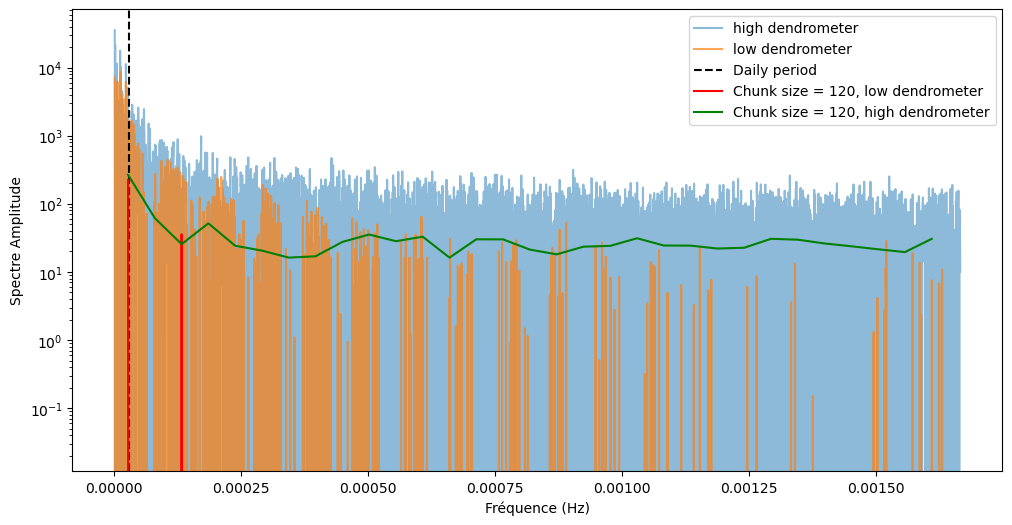

Harmoniques détectées signal 1:
Fréquence : 0.000027 Hz, Fréquence : 1.052778 jours, Amplitude : 224.98
Harmoniques détectées signal 2:
Fréquence : 0.000027 Hz, Fréquence : 1.052778 jours, Amplitude : 267.91


In [32]:
chunk_size = 120
frequencies1_avg_120, amplitudes1_avg_120 = average_by_chunk(frequencies1, amplitudes1, chunk_size)
frequencies2_avg_120, amplitudes2_avg_120 = average_by_chunk(frequencies2, amplitudes2, chunk_size)

plt.figure(figsize=(12, 6))
plt.semilogy(frequencies2, amplitudes2, label='high dendrometer', alpha=0.5)
plt.semilogy(frequencies1, amplitudes1, label='low dendrometer',alpha=0.7)
plt.axvline(x=1/(60*24*24), color='black', linestyle='--',label='Daily period')
plt.semilogy(frequencies1_avg_120, amplitudes1_avg_120,  label='Chunk size = 120, low dendrometer', color='red')
plt.semilogy(frequencies2_avg_120, amplitudes2_avg_120,  label='Chunk size = 120, high dendrometer', color='green')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Spectre Amplitude')
plt.legend()
plt.show()

print("Harmoniques détectées signal 1:")
print(f"Fréquence : {frequencies1_avg_120[0]:.6f} Hz, Fréquence : {freq_to_day(frequencies1_avg_120[0]):.6f} jours, Amplitude : {amplitudes1_avg_120[0]:.2f}")
print("Harmoniques détectées signal 2:")
print(f"Fréquence : {frequencies2_avg_120[0]:.6f} Hz, Fréquence : {freq_to_day(frequencies2_avg_120[0]):.6f} jours, Amplitude : {amplitudes2_avg_120[0]:.2f}")


**Observations**

On observe que pour une taulle de chunk de 120, la moyenne pour les 2 signaux est de 1.05 jours. Les résultats sont plus précis car on a plus une fenêtre plus grande correspondant à l'ensemble de l'harmonique d'ordre 1.

## Densité spectrale Welch

Dans cette partie nous nous intéressons à la méthode de Welch qui est l'équivalent d'une transformée de Fourier mais qui permet d'obtenir de meilleurs résultats.

In [35]:
from scipy.signal import welch

/opt/anaconda3/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 8192 is greater than input length  = 7580, using nperseg = 7580
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


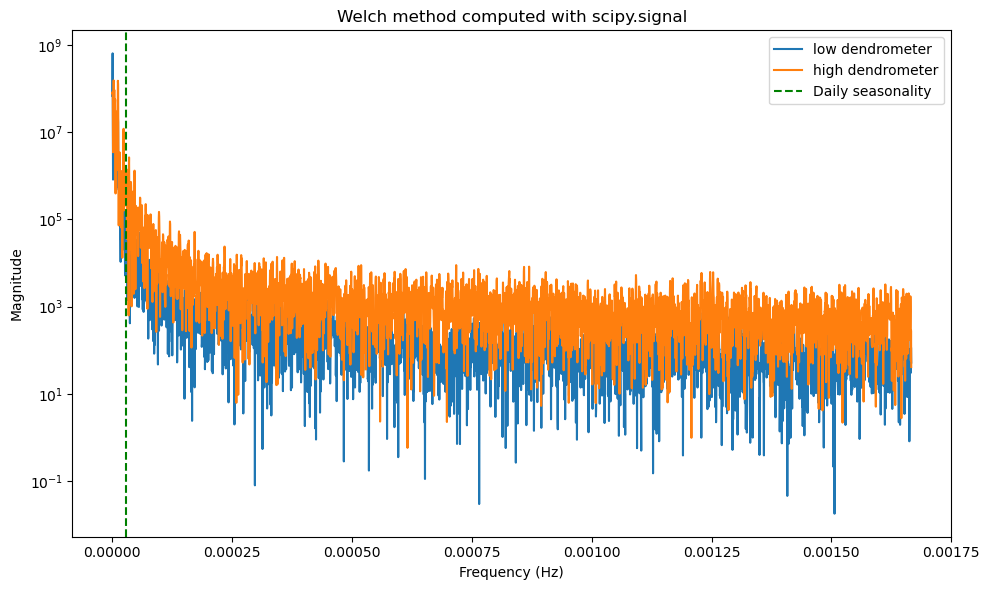

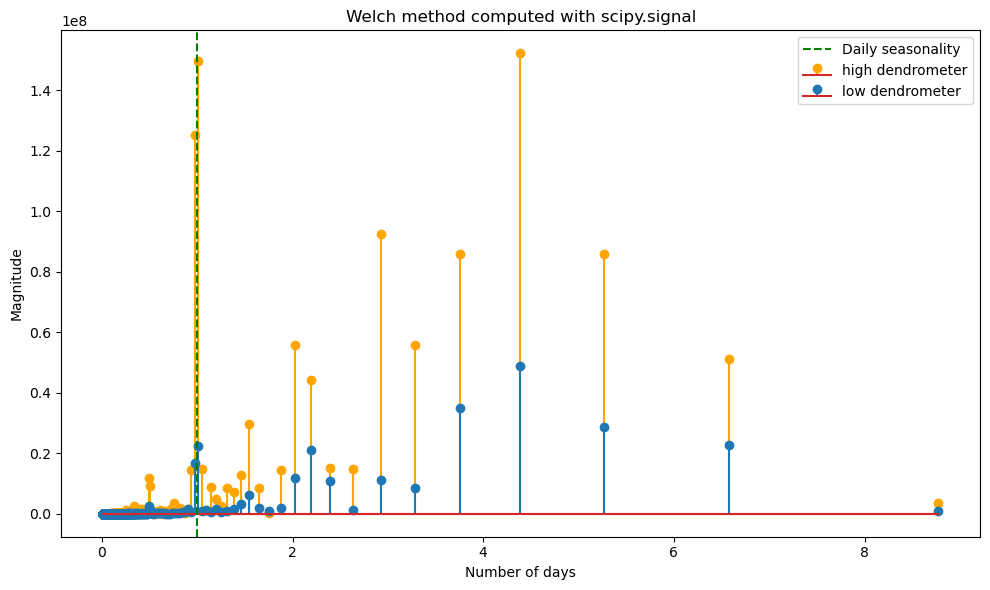

In [36]:
 #Paramètres de la méthode de Welch
nperseg = 8192 # 288
noverlap = int(nperseg/5)
fs = 1 / (60*5)

# Estimation de la PSD avec notre implémentation manuelle de Welch
frequencies_auto1, psd_auto1 = welch(time_serie_crop, fs=fs, nperseg=nperseg , noverlap=noverlap, window="hann", scaling = "density")
frequencies_auto2, psd_auto2 = welch(time_serie_crop2, fs=fs, nperseg=nperseg , noverlap=noverlap, window="hann", scaling = "density")

# Tracé du résultat
plt.figure(figsize=(10, 6))
plt.semilogy(frequencies_auto1, psd_auto1, label="low dendrometer")
plt.semilogy(frequencies_auto2, psd_auto2, label="high dendrometer")
plt.axvline(x=1/(60*24*24), color='green', linestyle='--',label='Daily seasonality')
plt.title('Welch method computed with scipy.signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.stem(((1/frequencies_auto2[3:len(frequencies_auto2)//2])/(60*60*24)), psd_auto2[3:len(psd_auto2)//2], label="high dendrometer", linefmt="orange")
plt.stem(((1/frequencies_auto1[3:len(frequencies_auto1)//2])/(60*60*24)), psd_auto1[3:len(psd_auto1)//2], label="low dendrometer")
plt.axvline(x=1, color='green', linestyle='--',label='Daily seasonality')
plt.title('Welch method computed with scipy.signal')
plt.xlabel('Number of days')
plt.ylabel('Magnitude')
plt.legend()
plt.tight_layout()
plt.show()


In [37]:
max_psd_index1 = np.argmax(np.abs(psd_auto1))
max_psd_frequency1 = frequencies_auto1[max_psd_index1]

max_psd_index2 = np.argmax(np.abs(psd_auto2))
max_psd_frequency2 = frequencies_auto2[max_psd_index2]


# Afficher la fréquence avec la plus grande PSD
print("---- Premiere PSD -----")
print(f"Fréquence avec la plus grande PSD pour low dendrometer : {(1/max_psd_frequency1)/(60*60*24)} j")
print(f"Fréquence avec la plus grande PSD pour high dendrometer : {(1/max_psd_frequency2)/(60*60*24)} j")

psd_auto1_without_max = np.abs(psd_auto1).copy()  
psd_auto1_without_max[max_psd_index1] = -np.inf  
second_max_psd_index1 = np.argmax(psd_auto1_without_max)  
second_max_psd_frequency1 = frequencies_auto1[second_max_psd_index1]  

psd_auto2_without_max = np.abs(psd_auto2).copy()  
psd_auto2_without_max[max_psd_index2] = -np.inf  
second_max_psd_index2 = np.argmax(psd_auto2_without_max)  
second_max_psd_frequency2 = frequencies_auto2[second_max_psd_index2]


print("---- Deuxieme PSD -----")
print(f"Fréquence avec la plus grande PSD pour low dendrometer : {(1/second_max_psd_frequency1)/(60*60*24)} j")
print(f"Fréquence avec la plus grande PSD pour high dendrometer : {(1/second_max_psd_frequency2)/(60*60*24)} j")

---- Premiere PSD -----
Fréquence avec la plus grande PSD pour low dendrometer : 26.319444444444443 j
Fréquence avec la plus grande PSD pour high dendrometer : 4.386574074074074 j
---- Deuxieme PSD -----
Fréquence avec la plus grande PSD pour low dendrometer : inf j
Fréquence avec la plus grande PSD pour high dendrometer : 1.0122863247863247 j


/var/folders/gn/sy_p6gyd0s15vprgs70pb0dr0000gn/T/ipykernel_4097/4212755117.py:25: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"Fréquence avec la plus grande PSD pour low dendrometer : {(1/second_max_psd_frequency1)/(60*60*24)} j")


**Observation**

On remarque ici que les composantes cycliques détectées lorsque l'on s'intéresse aux plus grande amplitudes des 2 signaux sont les mêmes que pour la transformée de Fourier.

Cependant si l'on regarde les 2e plus grandes on retrouve bien la composante du cycle diurne pour le 1er signal (orange). Nos résultats sont donc cohérents avec ceux obtenus précédemment. Si pour le 2e signal la composante du cycle diurne n'est aps détectée au bout de la 2e fois cela s'explique car on a pu observé qu'il était beaucoup plus bruité que l'autre.

# Modélisation des séries temporelles

Une fois l'étape de décomposition spectrale réalisée on va maintenant regarde comment modéliser ces signaux à l'aide de différentes librairies mais aussi à la main.

### Modélisation avec la librairie STL

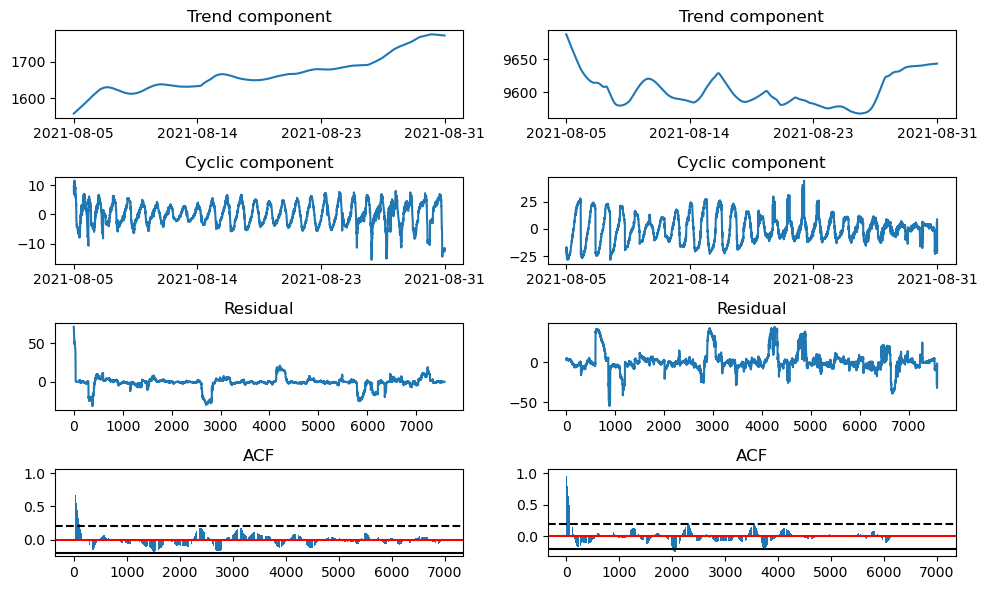

In [41]:
stl1 = STL(time_serie_crop, period=5*60, robust = True)
result_stl1 = stl1.fit()

stl2 = STL(time_serie_crop2, period=5*60, robust = True)
result_stl2 = stl2.fit()

max_lag = 7000
acf_values_1 = sm.tsa.acf(result_stl1.resid, nlags = max_lag)
acf_values_2 = sm.tsa.acf(result_stl2.resid, nlags = max_lag)

fig, ax = plt.subplots(4, 2, figsize=(10, 6))

num_ticks = 4
x_positions = np.linspace(0, len(datetime_data) - 1, num_ticks, dtype=int)
x_labels = [datetime_data[i] for i in x_positions]

ax[0,0].plot(datetime_data,result_stl1.trend)
ax[0,0].set_xticks(x_labels)
ax[0,0].set_title('Trend component')
ax[1,0].plot(datetime_data,result_stl1.seasonal)
ax[1,0].set_xticks(x_labels)
ax[1,0].set_title('Cyclic component')
ax[2,0].plot(result_stl1.resid)
ax[2,0].set_title('Residual')

ax[0,1].plot(datetime_data,result_stl2.trend)
ax[0,1].set_xticks(x_labels)
ax[0,1].set_title('Trend component')
ax[1,1].plot(datetime_data,result_stl2.seasonal)
ax[1,1].set_xticks(x_labels)
ax[1,1].set_title('Cyclic component')
ax[2,1].plot(result_stl2.resid)
ax[2,1].set_title('Residual')

ax[3,0].bar(range(max_lag + 1), acf_values_1)
ax[3,0].axhline(y=0.2, color='black', linestyle='--')
ax[3,0].axhline(y=0, color='red')
ax[3,0].axhline(y=-0.2, color='black')
ax[3,0].set_title('ACF')

ax[3,1].bar(range(max_lag + 1), acf_values_2)
ax[3,1].axhline(y=0.2, color='black', linestyle='--')
ax[3,1].axhline(y=0, color='red')
ax[3,1].axhline(y=-0.2, color='black')
ax[3,1].set_title('ACF')

plt.tight_layout()
plt.show()

**Observation**

Avec cette méthode, on peut observer que les résidus correspondent bien à des bruits blancs car leur autocorrélation ne présente qu'un seul pic supérieur à 0.2.

#### Intercorrelation

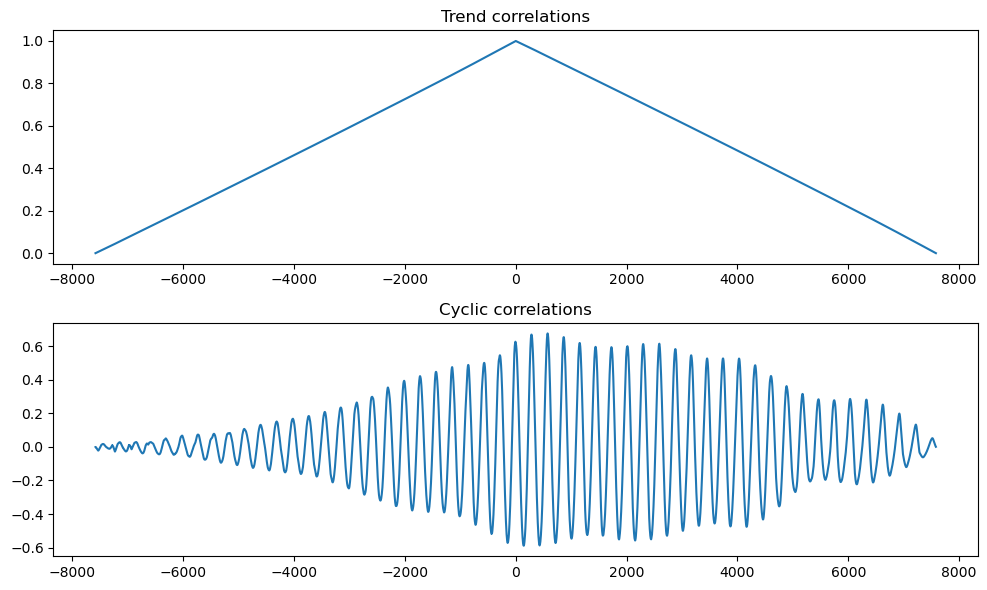

In [51]:
fig, ax = plt.subplots(2,1, figsize=(10, 6))

lags = scipy.signal.correlation_lags(len(result_stl1.trend), len(result_stl2.trend), mode='full')

corr_t = np.correlate(result_stl1.trend,result_stl2.trend,"full")
norm_factor = np.sqrt(np.sum(result_stl1.trend**2) * np.sum(result_stl2.trend**2))
corr_t_normalized = corr_t / norm_factor

ax[0].plot(lags,corr_t_normalized)
ax[0].set_title('Trend correlations')

corr_s = np.correlate(result_stl1.seasonal,result_stl2.seasonal,"full")
norm_factor = np.sqrt(np.sum(result_stl1.seasonal**2) * np.sum(result_stl2.seasonal**2))
corr_s_normalized = corr_s / norm_factor

ax[1].plot(lags,corr_s_normalized)
ax[1].set_title('Cyclic correlations')

plt.tight_layout()
plt.show()

In [53]:
print("--- Trend ---")
# Pearson's r
pearson = scipy.stats.pearsonr(result_stl1.trend,result_stl2.trend) 
print("Pearson corr = ",pearson[0]," - pvalue = ",pearson[1])   
# Spearman's rho
spearman = scipy.stats.spearmanr(result_stl1.trend,result_stl2.trend)   
print("Spearman corr = ",spearman[0]," - pvalue = ",spearman[1]) 
# Kendall's tau
kendall = scipy.stats.kendalltau(result_stl1.trend,result_stl2.trend)  
print("Kendall corr = ",kendall[0]," - pvalue = ",kendall[1])
print("--- Seasonalities ---")
# Pearson's r
pearson = scipy.stats.pearsonr(result_stl1.seasonal,result_stl2.seasonal) 
print("Pearson corr = ",pearson[0]," - pvalue = ",pearson[1])   
# Spearman's rho
spearman = scipy.stats.spearmanr(result_stl1.seasonal,result_stl2.seasonal)   
print("Spearman corr = ",spearman[0]," - pvalue = ",spearman[1]) 
# Kendall's tau
kendall = scipy.stats.kendalltau(result_stl1.seasonal,result_stl2.seasonal)  
print("Kendall corr = ",kendall[0]," - pvalue = ",kendall[1])

--- Trend ---
Pearson corr =  0.14903153884537756  - pvalue =  6.70280708088519e-39
Spearman corr =  -0.040277283129628895  - pvalue =  0.0004523147805247499
Kendall corr =  -0.05375344524047665  - pvalue =  2.2458438995708385e-12
--- Seasonalities ---
Pearson corr =  0.6201332296943063  - pvalue =  0.0
Spearman corr =  0.714589805768773  - pvalue =  0.0
Kendall corr =  0.5390956332958622  - pvalue =  0.0


### Modélisation avec la librairie MSTL

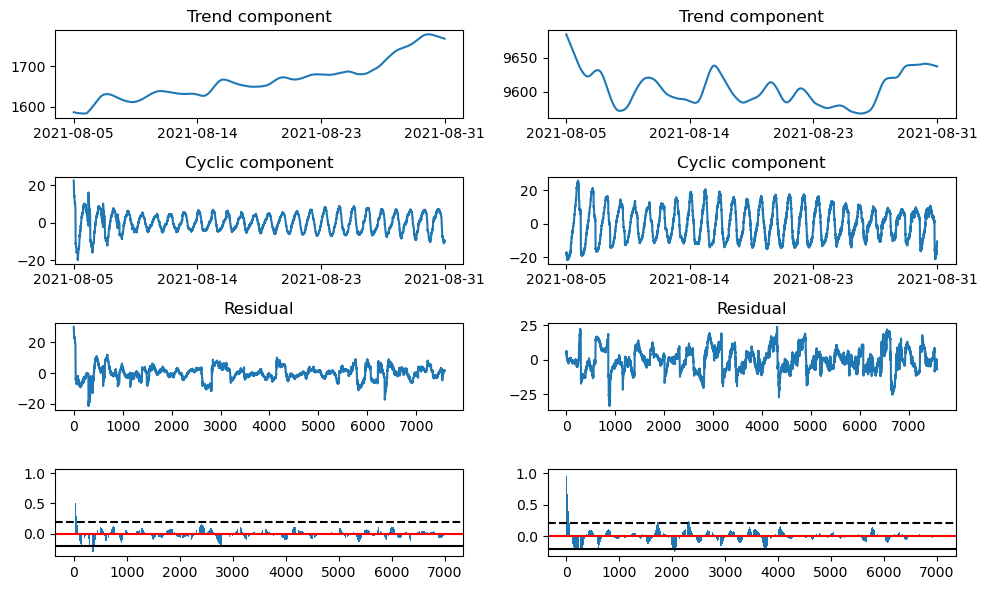

In [55]:
from statsmodels.tsa.seasonal import MSTL

mstl1 = MSTL(time_serie_crop, periods=5*60)
result_mstl1 = mstl1.fit()

mstl2 = MSTL(time_serie_crop2, periods=5*60)
result_mstl2 = mstl2.fit()

max_lag = 7000
acf_values_1 = sm.tsa.acf(result_mstl1.resid, nlags = max_lag)
acf_values_2 = sm.tsa.acf(result_mstl2.resid, nlags = max_lag)

fig, ax = plt.subplots(4, 2, figsize=(10, 6))

ax[0,0].plot(datetime_data,result_mstl1.trend)
ax[0,0].set_xticks(x_labels)
ax[0,0].set_title('Trend component')
ax[1,0].plot(datetime_data,result_mstl1.seasonal)
ax[1,0].set_xticks(x_labels)
ax[1,0].set_title('Cyclic component')
ax[2,0].plot(result_mstl1.resid)
ax[2,0].set_title('Residual')

ax[0,1].plot(datetime_data,result_mstl2.trend)
ax[0,1].set_xticks(x_labels)
ax[0,1].set_title('Trend component')
ax[1,1].plot(datetime_data,result_mstl2.seasonal)
ax[1,1].set_xticks(x_labels)
ax[1,1].set_title('Cyclic component')
ax[2,1].plot(result_mstl2.resid)
ax[2,1].set_title('Residual')

ax[3,0].bar(range(max_lag + 1), acf_values_1)
ax[3,0].axhline(y=0.2, color='black', linestyle='--')
ax[3,0].axhline(y=0, color='red')
ax[3,0].axhline(y=-0.2, color='black')

ax[3,1].bar(range(max_lag + 1), acf_values_2)
ax[3,1].axhline(y=0.2, color='black', linestyle='--')
ax[3,1].axhline(y=0, color='red')
ax[3,1].axhline(y=-0.2, color='black')

plt.tight_layout()
plt.show()

**Observation**

Avec cette méthode, on peut observer que les résidus correspondent bien à des bruits blancs car leur autocorrélation ne présente qu'un seul pic supérieur à 0.2.

#### Intercorrelation

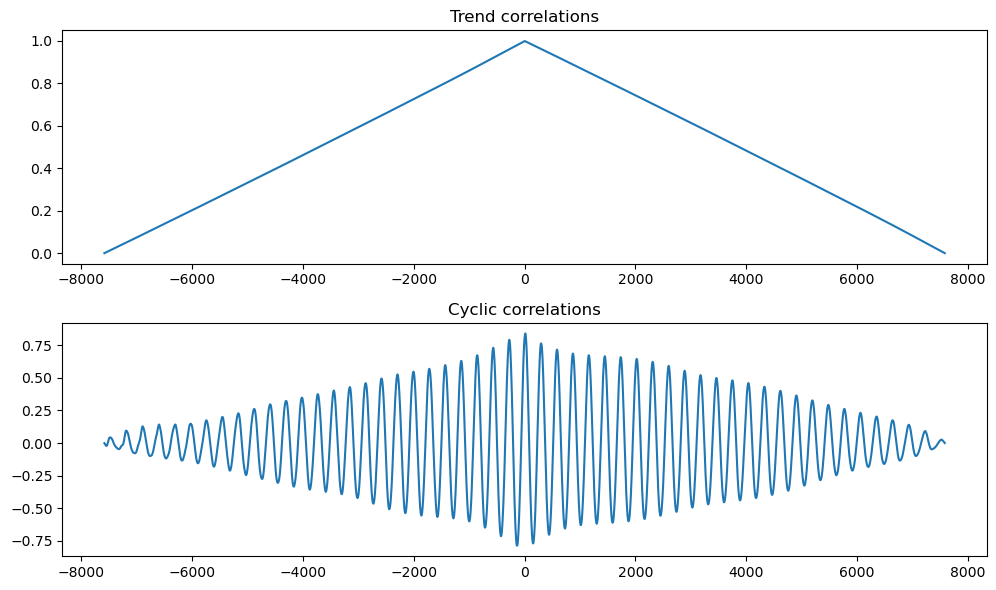

In [56]:
fig, ax = plt.subplots(2,1, figsize=(10, 6))
lags = scipy.signal.correlation_lags(len(result_mstl1.trend), len(result_mstl2.trend), mode='full')

corr_t = np.correlate(result_mstl1.trend,result_mstl2.trend, "full")
norm_factor = np.sqrt(np.sum(result_mstl1.trend**2) * np.sum(result_mstl2.trend**2))
corr_t_normalized = corr_t / norm_factor

ax[0].plot(lags,corr_t_normalized)
ax[0].set_title('Trend correlations')

corr_s = np.correlate(result_mstl1.seasonal,result_mstl2.seasonal, "full")
norm_factor = np.sqrt(np.sum(result_mstl1.seasonal**2) * np.sum(result_mstl2.seasonal**2))
corr_s_normalized = corr_s / norm_factor

ax[1].plot(lags,corr_s_normalized)
ax[1].set_title('Cyclic correlations')

plt.tight_layout()
plt.show()


In [57]:
print("--- Trend ---")
# Pearson's r
pearson = scipy.stats.pearsonr(result_mstl1.trend,result_mstl2.trend) 
print("Pearson corr = ",pearson[0]," - pvalue = ",pearson[1])   
# Spearman's rho
spearman = scipy.stats.spearmanr(result_mstl1.trend,result_mstl2.trend)   
print("Spearman corr = ",spearman[0]," - pvalue = ",spearman[1]) 
# Kendall's tau
kendall = scipy.stats.kendalltau(result_mstl1.trend,result_mstl2.trend)  
print("Kendall corr = ",kendall[0]," - pvalue = ",kendall[1])
print("--- Seasonalities ---")
# Pearson's r
pearson = scipy.stats.pearsonr(result_mstl1.seasonal,result_mstl2.seasonal) 
print("Pearson corr = ",pearson[0]," - pvalue = ",pearson[1])   
# Spearman's rho
spearman = scipy.stats.spearmanr(result_mstl1.seasonal,result_mstl2.seasonal)   
print("Spearman corr = ",spearman[0]," - pvalue = ",spearman[1]) 
# Kendall's tau
kendall = scipy.stats.kendalltau(result_mstl1.seasonal,result_mstl2.seasonal)  
print("Kendall corr = ",kendall[0]," - pvalue = ",kendall[1])

--- Trend ---
Pearson corr =  0.16939920679364473  - pvalue =  6.605883059227862e-50
Spearman corr =  0.021732664709482867  - pvalue =  0.05848743338949287
Kendall corr =  0.027295599805183115  - pvalue =  0.0003654682031995368
--- Seasonalities ---
Pearson corr =  0.8057624905841926  - pvalue =  0.0
Spearman corr =  0.844761394045857  - pvalue =  0.0
Kendall corr =  0.6891113864479723  - pvalue =  0.0


### Modélisation avec seasonal_decompose

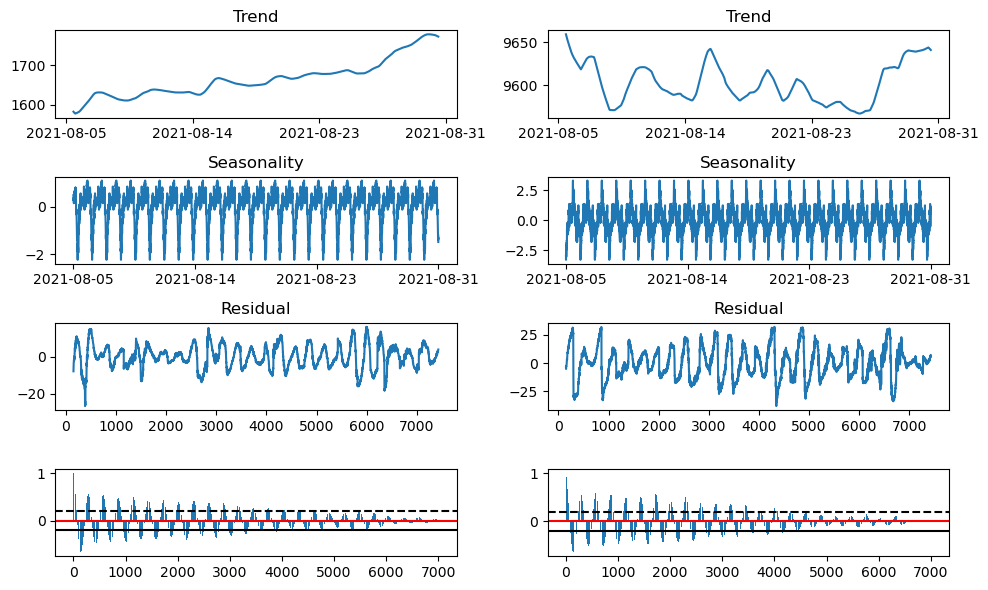

In [58]:
from statsmodels.tsa.seasonal import seasonal_decompose

result_sd1 = seasonal_decompose(time_serie_crop, model='additive', period=60*5)
result_sd2 = seasonal_decompose(time_serie_crop2, model='additive', period=60*5)

max_lag = 7000
acf_values_1 = sm.tsa.acf(result_sd1.resid, nlags = max_lag, missing="drop")
acf_values_2 = sm.tsa.acf(result_sd2.resid, nlags = max_lag, missing="drop")

fig, ax = plt.subplots(4, 2, figsize=(10, 6))

ax[0,0].plot(datetime_data,result_sd1.trend)
ax[0,0].set_xticks(x_labels)
ax[0,0].set_title('Trend')
ax[1,0].plot(datetime_data,result_sd1.seasonal)
ax[1,0].set_xticks(x_labels)
ax[1,0].set_title('Seasonality')
ax[2,0].plot(result_sd1.resid)
ax[2,0].set_title('Residual')

ax[0,1].plot(datetime_data,result_sd2.trend)
ax[0,1].set_xticks(x_labels)
ax[0,1].set_title('Trend')
ax[1,1].plot(datetime_data,result_sd2.seasonal)
ax[1,1].set_xticks(x_labels)
ax[1,1].set_title('Seasonality')
ax[2,1].plot(result_sd2.resid)
ax[2,1].set_title('Residual')

ax[3,0].bar(range(max_lag + 1), acf_values_1)
ax[3,0].axhline(y=0.2, color='black', linestyle='--')
ax[3,0].axhline(y=0, color='red')
ax[3,0].axhline(y=-0.2, color='black')

ax[3,1].bar(range(max_lag + 1), acf_values_2)
ax[3,1].axhline(y=0.2, color='black', linestyle='--')
ax[3,1].axhline(y=0, color='red')
ax[3,1].axhline(y=-0.2, color='black')

plt.tight_layout()
plt.show()

**Observation**

Avec cette méthode, on peut observer que les résidus ne correspondent pas à des bruits blancs car leur autocorrélation présente plusieurs pics supérieurs à 0.2. En effet, si l'on regarde de plus près les résidus, on voit une saisonnalité encore. 

Cette méthode n'est donc pas la meilleure pour modéliser nos signaux et isoler correctement leur tendance et leur saisonnalité.

#### Intercorrelation

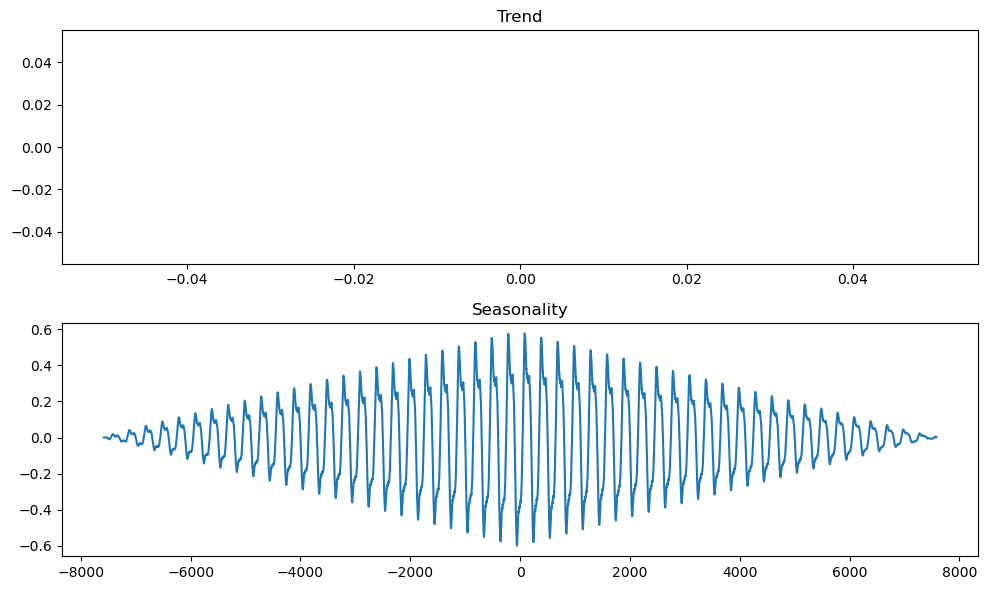

In [62]:
fig, ax = plt.subplots(2,1, figsize=(10, 6))

lags = scipy.signal.correlation_lags(len(result_sd1.trend), len(result_sd2.trend), mode='full')
corr_t = np.correlate(result_sd1.trend,result_sd2.trend,"full")
norm_factor = np.sqrt(np.sum(result_sd1.trend**2) * np.sum(result_sd2.trend**2))
corr_t_normalized = corr_t / norm_factor

ax[0].plot(lags,corr_t_normalized)
ax[0].set_title('Trend')

corr_s = np.correlate(result_sd1.seasonal,result_sd2.seasonal,"full")
norm_factor = np.sqrt(np.sum(result_sd1.seasonal**2) * np.sum(result_sd2.seasonal**2))
corr_s_normalized = corr_s / norm_factor

ax[1].plot(lags,corr_s_normalized)
ax[1].set_title('Seasonality')

plt.tight_layout()
plt.show()

# Analyse de la saisonnalité (périodes et déphasage)

On cherche dans cette méthode à comparer les saisonnalités obtenues pour les 2 signaux. En efffet on est censés retrouvé une période correspondant à un jour. Cependant, les dendromètres ne sont pas placés à la même hauteur donc on s'attend à observer une différence de phase.

## STL

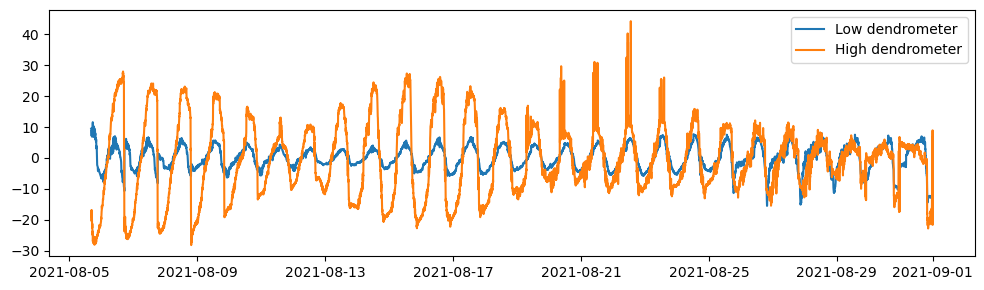

In [65]:
plt.figure(figsize=(10, 3))
plt.plot(datetime_data,result_stl1.seasonal, label = "Low dendrometer")
plt.plot(datetime_data,result_stl2.seasonal, label = "High dendrometer")
plt.legend()
plt.tight_layout()
plt.show()

In [66]:
seasonal1 = result_stl1.seasonal
seasonal2 = result_stl2.seasonal

amplitudes1 = np.real(np.fft.rfft(seasonal1))
frequencies1 = np.fft.rfftfreq(len(seasonal1),5*60) 
amplitudes2 = np.real(np.fft.rfft(seasonal2))
frequencies2 = np.fft.rfftfreq(len(seasonal2),5*60) 

peaks1, _ = scipy.signal.find_peaks(amplitudes1, height=np.mean(amplitudes1) * 0.03)
frequence_principale1 = frequencies1[peaks1[0]] 
periode_principale1 = 1 / frequence_principale1
peaks2, _ = scipy.signal.find_peaks(amplitudes2, height=np.mean(amplitudes2) * 0.03)
frequence_principale2 = frequencies2[peaks2[0]] 
periode_principale2 = 1 / frequence_principale2

print(f"Série 1 --> Fréquence dominante : {frequence_principale1*1e8:.5f} 1e-8 Hz, soit une période d'environ {periode_principale1 / (3600*24):.2f} jours")
print(f"Série 2 --> Fréquence dominante : {frequence_principale2*1e8:.5f} 1e-8 Hz, soit une période d'environ {periode_principale2 / (3600*24):.2f} jours")

Série 1 --> Fréquence dominante : 879.50748 1e-8 Hz, soit une période d'environ 1.32 jours
Série 2 --> Fréquence dominante : 1187.33509 1e-8 Hz, soit une période d'environ 0.97 jours


Déphasage : -20.0 min


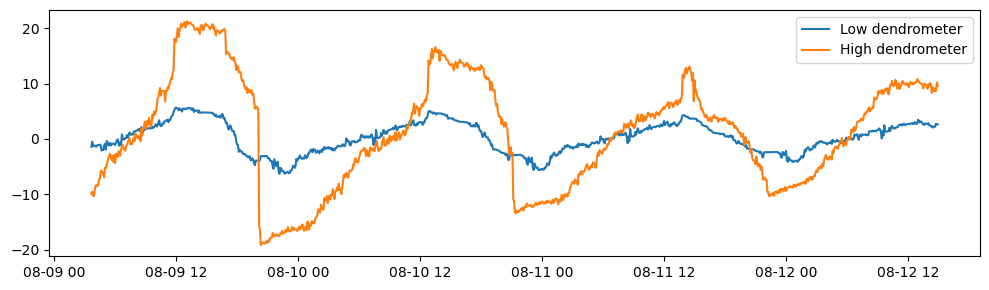

In [67]:
# Détection des pics des deux signaux
peaks1, _ = scipy.signal.find_peaks(seasonal1)
peaks2, _ = scipy.signal.find_peaks(seasonal2)

# Calcul du temps des premiers pics (déphasage temporel)
time_peak1 = datetime_data[peaks1[0]]  # Premier pic du signal 1
time_peak2 = datetime_data[peaks2[0]]  # Premier pic du signal 2

# Déphasage temporel
delta_t = (time_peak2 - time_peak1).total_seconds()

print(f"Déphasage : {delta_t/60:.1f} min")

# Affichage du déphasage
plt.figure(figsize=(10, 3))
plt.plot(datetime_data[1000:2000],result_stl1.seasonal[1000:2000], label = "Low dendrometer")
plt.plot(datetime_data[1000:2000],result_stl2.seasonal[1000:2000], label = "High dendrometer")
plt.legend()
plt.tight_layout()
plt.show()

**Observation**

Si l'on regarde sur une fenêtre zoomée on voit bien que nos signaux sont périodiques avec une période presque similaire (0.97 jours et 1.32 jours) et on observe bien un déphasage. Lorsque l'on calcule ce déphasage on obtient un écart de 20 min entre les deux.

Pour conclure la méthode STL nous permet de bien isoler à la fois la tendance et la saisonnalité de nos signaux. On peut aussi observer grâce à cette méthode des différences entre différents signaux tel que le déphasage.

## MSTL

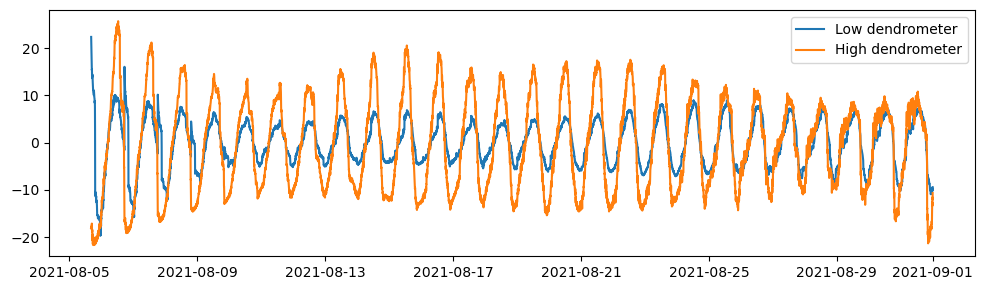

In [70]:
plt.figure(figsize=(10, 3))
plt.plot(datetime_data,result_mstl1.seasonal, label = "Low dendrometer")
plt.plot(datetime_data,result_mstl2.seasonal, label = "High dendrometer")
plt.legend()
plt.tight_layout()
plt.show()

In [71]:
seasonal1 = result_mstl1.seasonal
seasonal2 = result_mstl2.seasonal

amplitudes1 = np.real(np.fft.rfft(seasonal1))
frequencies1 = np.fft.rfftfreq(len(seasonal1),5*60) 
amplitudes2 = np.real(np.fft.rfft(seasonal2))
frequencies2 = np.fft.rfftfreq(len(seasonal2),5*60) 

peaks1, _ = scipy.signal.find_peaks(amplitudes1, height=np.mean(amplitudes1) * 0.03)
frequence_principale1 = frequencies1[peaks1[0]] 
periode_principale1 = 1 / frequence_principale1
peaks2, _ = scipy.signal.find_peaks(amplitudes2, height=np.mean(amplitudes2) * 0.03)
frequence_principale2 = frequencies2[peaks2[0]] 
periode_principale2 = 1 / frequence_principale2

print(f"Série 1 --> Fréquence dominante : {frequence_principale1*1e8:.5f} 1e-8 Hz, soit une période d'environ {periode_principale1 / (3600*24):.2f} jours")
print(f"Série 2 --> Fréquence dominante : {frequence_principale2*1e8:.5f} 1e-8 Hz, soit une période d'environ {periode_principale2 / (3600*24):.2f} jours")

Série 1 --> Fréquence dominante : 1231.31047 1e-8 Hz, soit une période d'environ 0.94 jours
Série 2 --> Fréquence dominante : 1187.33509 1e-8 Hz, soit une période d'environ 0.97 jours


Déphasage : -25.0 min


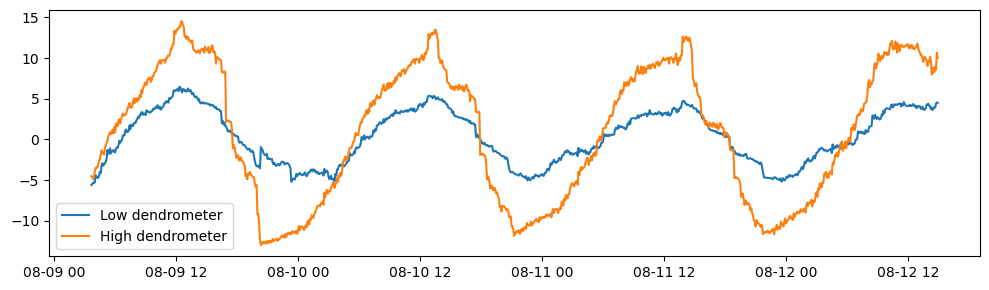

In [72]:
# Détection des pics des deux signaux
peaks1, _ = scipy.signal.find_peaks(seasonal1)
peaks2, _ = scipy.signal.find_peaks(seasonal2)

# Calcul du temps des premiers pics (déphasage temporel)
time_peak1 = datetime_data[peaks1[0]]  # Premier pic du signal 1
time_peak2 = datetime_data[peaks2[0]]  # Premier pic du signal 2

# Déphasage temporel
delta_t = (time_peak2 - time_peak1).total_seconds()

print(f"Déphasage : {delta_t/60:.1f} min")

# Affichage du déphasage
plt.figure(figsize=(10, 3))
plt.plot(datetime_data[1000:2000],result_mstl1.seasonal[1000:2000], label = "Low dendrometer")
plt.plot(datetime_data[1000:2000],result_mstl2.seasonal[1000:2000], label = "High dendrometer")
plt.legend()
plt.tight_layout()
plt.show()

**Observation**

Si l'on regarde sur une fenêtre zoomée on voit bien que nos signaux sont périodiques avec une période presque similaire (0.97 jours et 0.97 jours) et on observe bien un déphasage. Lorsque l'on calcule ce déphasage on obtient un écart de 25 min entre les deux.

Pour conclure la méthode MSTL nous permet de bien isoler à la fois la tendance et la saisonnalité de nos signaux. On peut aussi observer grâce à cette méthode des différences entre différents signaux tel que le déphasage.

On va préférer cette méthode à celle de STL car lorsque l'on calcule les périodes des saisonnalités obtenus nos résultats sont plus précis.

## Seasonal Decompose (SD)

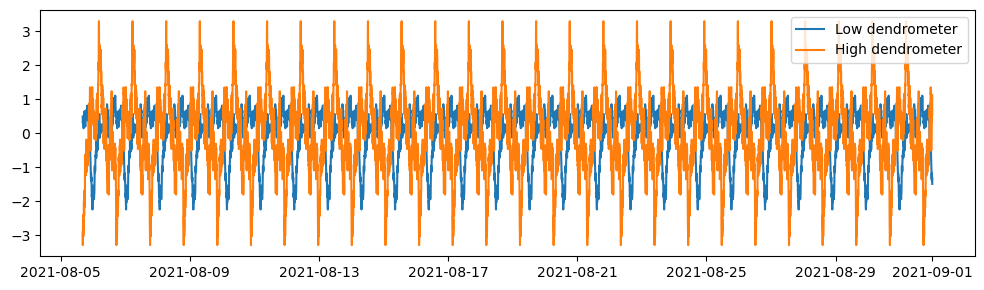

In [75]:
plt.figure(figsize=(10, 3))
plt.plot(datetime_data, result_sd1.seasonal, label = "Low dendrometer")
plt.plot(datetime_data,result_sd2.seasonal, label = "High dendrometer")
plt.legend()
plt.tight_layout()
plt.show()

In [76]:
seasonal1 = result_sd1.seasonal
seasonal2 = result_sd2.seasonal

amplitudes1 = np.real(np.fft.rfft(seasonal1))
frequencies1 = np.fft.rfftfreq(len(seasonal1),5*60) 
amplitudes2 = np.real(np.fft.rfft(seasonal2))
frequencies2 = np.fft.rfftfreq(len(seasonal2),5*60) 

peaks1, _ = scipy.signal.find_peaks(amplitudes1, height=np.mean(amplitudes1) * 0.03)
frequence_principale1 = frequencies1[peaks1[0]] 
periode_principale1 = 1 / frequence_principale1
peaks2, _ = scipy.signal.find_peaks(amplitudes2, height=np.mean(amplitudes2) * 0.03)
frequence_principale2 = frequencies2[peaks2[0]] 
periode_principale2 = 1 / frequence_principale2

print(f"Série 1 --> Fréquence dominante : {frequence_principale1*1e8:.5f} 1e-8 Hz, soit une période d'environ {periode_principale1 / (3600*24):.2f} jours")
print(f"Série 2 --> Fréquence dominante : {frequence_principale2*1e8:.5f} 1e-8 Hz, soit une période d'environ {periode_principale2 / (3600*24):.2f} jours")

Série 1 --> Fréquence dominante : 1143.35972 1e-8 Hz, soit une période d'environ 1.01 jours
Série 2 --> Fréquence dominante : 1143.35972 1e-8 Hz, soit une période d'environ 1.01 jours


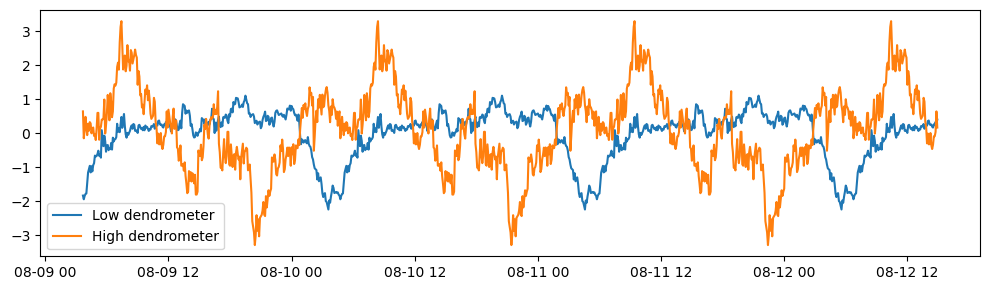

In [77]:
# Détection des pics des deux signaux
peaks1, _ = scipy.signal.find_peaks(seasonal1)
peaks2, _ = scipy.signal.find_peaks(seasonal2)

# Calcul du temps des premiers pics (déphasage temporel)
time_peak1 = datetime_data[peaks1[0]]  # Premier pic du signal 1
time_peak2 = datetime_data[peaks2[0]]  # Premier pic du signal 2

# Déphasage temporel
delta_t = (time_peak2 - time_peak1).total_seconds()

#print(f"Déphasage : {delta_t/60:.1f} min")

# Affichage du déphasage
plt.figure(figsize=(10, 3))
plt.plot(datetime_data[1000:2000],result_sd1.seasonal[1000:2000], label = "Low dendrometer")
plt.plot(datetime_data[1000:2000],result_sd2.seasonal[1000:2000], label = "High dendrometer")
plt.legend()
plt.tight_layout()
plt.show()

**Observation**

Si l'on regarde sur une fenêtre zoomée on voit bien que nos signaux sont périodiques avec une période similaire (1.01 jours). Néanmoins on observe pas de déphasage.

Pour conclure la méthode SD ne nous permet pas de bien isoler notre tendance et notre saisonnalité et ne nous permet pas non plus de détecter un déphasage.